# En este modelo se entrena un modelo Resnet50 SSD

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="tvpbe4I4XLcB14dkNovn")
project = rf.workspace("myworkspace-iraqv").project("wildfire_full")
version = project.version(1)
dataset = version.download("tensorflow")


In [3]:
#Clonamos el repositorio que aloja los distintos modelos de Tensorflow
!git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 98785, done.
remote: Counting objects: 100% (1292/1292), done.
remote: Compressing objects: 100% (660/660), done.
remote: Total 98785 (delta 707), reused 1085 (delta 604), pack-reused 97493 (from 1)
Receiving objects: 100% (98785/98785), 622.31 MiB | 27.82 MiB/s, done.
Resolving deltas: 100% (71700/71700), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

#Tarda 2 min

In [ ]:
pip install tensorflow==2.13.1
#Por conflicto de dependencias, necesitamos esa version

In [ ]:
! pip uninstall protobuf
! pip install protobuf==3.20.0
#Idem, se requierere esa version de protobuf

In [7]:
from object_detection.builders import model_builder
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils

In [8]:
import os
import pathlib
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
# Cargamos las anotaciones y los path a las imagenes
import pandas as pd

# Verifica la ruta absoluta del archivo
train_data_path = os.path.abspath('/content/Wildfire_Full-1/train/')
print("Ruta completa al dataset de train:", train_data_path)

test_data_path = os.path.abspath('Wildfire_Full-1/test/')
print("Ruta completa al dataset de test:", test_data_path)

valid_data_path = os.path.abspath('Wildfire_Full-1/valid/')
print("Ruta completa al dataset de valid:", valid_data_path)

train_annotations_path = os.path.join(train_data_path, '_annotations.csv')
# Cargar las anotaciones
train_annotations = pd.read_csv(train_annotations_path)
print("Estructura de las anotaciones:")
train_annotations.head()

Ruta completa al dataset de train: /content/Wildfire_Full-1/train
Ruta completa al dataset de test: /content/Wildfire_Full-1/test
Ruta completa al dataset de valid: /content/Wildfire_Full-1/valid
Estructura de las anotaciones:


,filename,width,height,class,xmin,ymin,xmax,ymax
0,52355484724_b8cb1c7bb1_o_jpg.rf.456de39a89a9aa...,640,640,Smoke,0,0,640,312
1,43251632962_0a4d318bba_o_jpg.rf.43b681e5a68c85...,640,640,Smoke,0,0,173,325
2,43251632962_0a4d318bba_o_jpg.rf.43b681e5a68c85...,640,640,Smoke,140,37,279,278
3,43251632962_0a4d318bba_o_jpg.rf.43b681e5a68c85...,640,640,Smoke,334,68,596,213
4,50295006206_a6250175c7_o_jpg.rf.3f6a2a15bf5c9e...,640,640,Fire,335,402,362,443


# Cargamos el modelo

Vamos a usar un modelo de **ResNet50 SSD** de tensorflow, el mismo combina dos arquitecturas poderosas:

- `ResNet50 (Residual Network 50)`:
*Descripción* : Es una red neuronal profunda con 50 capas, diseñada para tareas de reconocimiento de imágenes. Introduce "bloques residuales" que permiten entrenar redes muy profundas sin enfrentar problemas de degradación del rendimiento.
- `SSD (Single Shot MultiBox Detector):`
Es un modelo de detección de objetos que realiza predicciones de cajas delimitadoras y clases en una sola pasada (de ahí "Single Shot").
Ventaja: Es rápido y eficiente, adecuado para aplicaciones en tiempo real.

In [11]:
!wget  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2024-12-05 19:16:06--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.203.207, 142.250.98.207, 74.125.134.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.203.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   198MB/s    in 1.2s    

2024-12-05 19:16:07 (198 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [12]:
#Configuramos el modelo:
model_name = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8'
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/' + model_name + '.config')
model_dir = 'models/research/object_detection/test_data/checkpoint/'

In [13]:
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']

#Una vez configurado, instanciamos el modelo:
detection_model = model_builder.build(model_config=model_config, is_training=False) #False para probarlo

**model_name**: Nombre del modelo preentrenado a usar.

**pipeline_config**: Ruta al archivo de configuración del pipeline del modelo. Este archivo contiene toda la configuración necesaria para entrenar y evaluar el modelo, como la arquitectura, hiperparámetros, rutas a datos, etc.

**model_dir**: Ruta al directorio donde se encuentran los checkpoints del modelo preentrenado.

**configs** = config_util.get_configs_from_pipeline_file(pipeline_config): Carga las configuraciones del archivo de pipeline.

**model_config** = configs['model']: Extrae la configuración específica del modelo.

In [14]:
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)   #permitirá restaurar el estado del modelo preentrenado.
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()  #Restaura el modelo desde el checkpoint especificado

In [15]:
def get_model_detection_function(model):

  @tf.function
  def detect_fn(image):
    image, shape = model.preprocess(image)
    prediction_dict = model.predict(image, shape)
    detections = model.postprocess(prediction_dict, shape)

    return detections

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [16]:
# Diccionario de etiquetas
label_map_dict = {
    1: {'name': 'Fire'},
    2: {'name': 'Smoke'}
}

# Ruta del archivo de etiquetas
label_map_path = 'models/research/object_detection/data/custom_label_map.pbtxt'

# Crear el archivo de etiquetas
with tf.io.gfile.GFile(label_map_path, 'w') as f:
    for id, label in label_map_dict.items():
        f.write('item {\n')
        f.write('  id: {}\n'.format(id))
        f.write('  name: \'{}\'\n'.format(label['name']))
        f.write('}\n\n')

In [17]:
from object_detection.utils import label_map_util

label_map_path = configs['eval_input_config'].label_map_path
label_map_path = 'models/research/object_detection/data/custom_label_map.pbtxt'

label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(        #Convierte el mapa de etiquetas a una lista de categorías.
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),    #Crea un diccionario que mapea los IDs de clase a sus nombres.
    use_display_name=True
)

category_index = label_map_util.create_category_index(categories)    #Carga el mapa de etiquetas desde el archivo especificado.
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)   #Crea un diccionario que mapea los nombres de clase a sus IDs.

- **label_map_util**: Utilidades para manejar mapas de etiquetas (label maps), que asocian IDs de clases con nombres legibles.

- **label_map_path** = configs['eval_input_config'].label_map_path: Inicialmente, intenta obtener la ruta del mapa de etiquetas desde la configuración del pipeline.

- **label_map_path** = 'models/research/object_detection/data/mscoco_label_map.pbtxt': Luego, sobrescribe label_map_path con la ruta al mapa de etiquetas de COCO. Esto es un problema, ya que tu tarea tiene solo dos clases (fuego y humo), mientras que COCO tiene 90 clases.

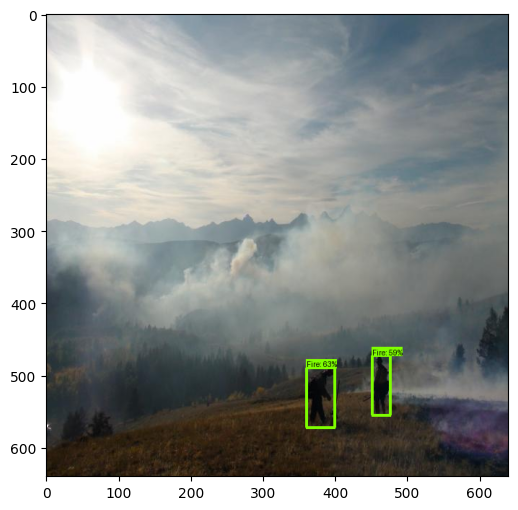

In [111]:
#Vamos a usar el modelo para detectar objetos con los que ya fue entrenado
%matplotlib inline

img = cv2.imread('/content/Wildfire_Full-1/train/11713547914_dd11630b77_o_jpg.rf.b0e67053d70e288855d8e6a9654a00af.jpg')
image_np = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32
)
detections = detect_fn(input_tensor)

label_id_offset = 1  #Las labels son 1 y 2, las listas empiezan desde 0
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'][0].numpy(),
    (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
    detections['detection_scores'][0].numpy(),
    category_index,
    use_normalized_coordinates=True,
    min_score_thresh=0.4
)

plt.figure(figsize=(8, 6))
plt.imshow(image_np_with_detections)
plt.show()

Detecta a dos personas, como cambiamos el dicctionario de clases, aparecen como `Fire`, pero son personas

# Fine Tunning del modelo

In [18]:
from object_detection.utils import config_util
from object_detection.builders import model_builder

num_classes = 2
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head
)

fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=detection_model.feature_extractor,  # ResNet-50
    _box_predictor=fake_box_predictor
)

ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)

ckpt.restore(checkpoint_path).expect_partial()

In [ ]:
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

Se realiza una pasada de prueba con una imagen de ceros para asegurarse de que el modelo está correctamente construido y puede procesar una imagen.

In [19]:
gt_boxes = []
images_added = []
images_multi_bbox = set()

for index, row in train_annotations.iterrows():
  if row['filename'] not in images_added and row['class'] == 'Smoke':
    images_added.append(row['filename'])
    bbox = np.array([[row['ymin']/640, row['xmin']/640, row['ymax']/640, row['xmax']/640]], dtype=np.float32)
    gt_boxes.append(bbox)
  else:
    images_multi_bbox.add(row['filename'])

#Aca tuvimos que probar sacando las imagenes que tenian mas de un bb.

id_x_to_delete = []
for x, image in enumerate(images_added):
  if image in images_multi_bbox:
    id_x_to_delete.append(x)

new_gt_boxes = []
new_images_added = []
for x, gt_box in enumerate(gt_boxes):
  if x not in  id_x_to_delete:
    new_gt_boxes.append(gt_box)

for x, image_added in enumerate(images_added):
  if x not in id_x_to_delete:
    new_images_added.append(image_added)

gt_boxes = new_gt_boxes
images_added = new_images_added


In [118]:
my_path = train_data_path + '/'
train_images_np = []
print('images_added: ',len(images_added))
for image in images_added:
  im = cv2.imread(my_path+ image)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  train_images_np.append(im)

label_id_offset = 0
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_ground_truth_classes = tf.convert_to_tensor(np.ones([gt_box_np.shape[0]], dtype=np.int32)-label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_ground_truth_classes, num_classes))


print('train_image_tensors: ',len(train_image_tensors))

images_added:  171
train_image_tensors:  171


In [49]:
tf.keras.backend.set_learning_phase(True)   #Cambiamos a train mode

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [186]:
batch_size = 10
learning_rate= 0.0004
num_epochs = 30

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'
]

for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

In [157]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):

  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list
    )

    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
          for image_tensor in image_tensors], axis=0
      )
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = (3*losses_dict['Loss/localization_loss']) + losses_dict['Loss/classification_loss']   #mas peso a la ubicacion que a la clase y luego al reves
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss

  return train_step_fn

tf.keras.backend.set_learning_phase(True): Configura Keras para el modo de entrenamiento, lo cual es necesario para ciertas capas como Batch Normalization y Dropout.

Configuración de Hiperparámetros:

batch_size = 10: Tamaño del batch para el entrenamiento.
learning_rate = 0.0005: Tasa de aprendizaje para el optimizador.
num_batches = 100: Número total de batches para entrenar.
Selección de Variables Entrenables:

trainable_variables: Obtiene todas las variables del modelo que son entrenables.
to_fine_tune: Lista para almacenar las variables que se van a afinar (fine-tune).
prefixes_to_train: Prefijos de los nombres de las variables que se van a entrenar. Solo las variables que comienzan con estos prefijos serán incluidas en to_fine_tune.

In [187]:
optimizer= tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)   #Para usar el modelo cargado

In [ ]:
for idx in range(num_epochs):
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]
  image_list = [train_images_np[key] for key in example_keys]

  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_epochs) + ', loss= ' + str(total_loss), flush=True)


batch 0 of 30, loss= tf.Tensor(2.091528, shape=(), dtype=float32)
batch 10 of 30, loss= tf.Tensor(1.385319, shape=(), dtype=float32)
batch 20 of 30, loss= tf.Tensor(1.5882311, shape=(), dtype=float32)


Notas:
- 1: Se entrenó de a partes. Epocas de 10.
- Se fue cambiando el peso de las loss. Priorizando la ubicacion de las bounding boxes y luego el de clasificacion. Se llego a una loss de 1.37 cuando se ponderaba mas a ubicacion

In [25]:
#Definimos la funcion para predecir
def detect(input_tensor):
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  predict_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(predict_dict, shapes)

# Guardar el modelo

In [ ]:
import tensorflow as tf

# Define la función de inferencia con una firma de entrada concreta
@tf.function(input_signature=[tf.TensorSpec([None, 640, 640, 3], tf.float32, name='input_image')])
def serve_fn(images):
    preprocessed_images, shapes = detection_model.preprocess(images)
    prediction_dict = detection_model.predict(preprocessed_images, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Define la ruta donde se guardará el modelo
export_dir = 'exported_model'

# Guarda el modelo con la función de firma
tf.saved_model.save(
    detection_model,
    export_dir,
    signatures={'serving_default': serve_fn}
)

print(f"Modelo guardado exitosamente en {export_dir}")


Modelo guardado exitosamente en exported_model


In [ ]:
#Para conectar al Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [35]:
import os

# Define la ruta en Google Drive
drive_export_dir = '/content/drive/MyDrive/modelos_exportados/exported_model'

# Crea el directorio si no existe
os.makedirs(drive_export_dir, exist_ok=True)


In [ ]:
import tensorflow as tf

# Define la función de firma con una firma de entrada concreta
@tf.function(input_signature=[tf.TensorSpec([None, 640, 640, 3], tf.float32, name='input_image')])
def serve_fn(images):
    preprocessed_images, shapes = detection_model.preprocess(images)
    prediction_dict = detection_model.predict(preprocessed_images, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Guarda el modelo en Google Drive
tf.saved_model.save(
    detection_model,
    drive_export_dir,
    signatures={'serving_default': serve_fn}
)

print(f"Modelo guardado exitosamente en {drive_export_dir}")


Modelo guardado exitosamente en /content/drive/MyDrive/modelos_exportados/exported_model


In [36]:
# Descargamos la carpeta desde google Drive
!zip -r /content/exported_model.zip {drive_export_dir}

updating: content/drive/MyDrive/modelos_exportados/exported_model/ (stored 0%)


In [ ]:
from google.colab import files
files.download('/content/exported_model.zip')
#Descargamos a local para tener el modelo localmente

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
!unzip /content/exported_model.zip -d /content/

Archive:  /content/exported_model.zip
   creating: /content/content/drive/MyDrive/modelos_exportados/exported_model/
   creating: /content/content/drive/MyDrive/modelos_exportados/exported_model/variables/
  inflating: /content/content/drive/MyDrive/modelos_exportados/exported_model/variables/variables.data-00000-of-00001  
  inflating: /content/content/drive/MyDrive/modelos_exportados/exported_model/variables/variables.index  
   creating: /content/content/drive/MyDrive/modelos_exportados/exported_model/assets/
 extracting: /content/content/drive/MyDrive/modelos_exportados/exported_model/fingerprint.pb  
  inflating: /content/content/drive/MyDrive/modelos_exportados/exported_model/saved_model.pb  


In [41]:
#Una vez guardado en el drive, cargamos el modelo
drive_export_dir = '/content/content/drive/MyDrive/modelos_exportados/exported_model'

loaded_model = tf.saved_model.load(drive_export_dir)

/content/content/drive/MyDrive/modelos_exportados/exported_model:
assets	fingerprint.pb	saved_model.pb	variables

/content/content/drive/MyDrive/modelos_exportados/exported_model/assets:

/content/content/drive/MyDrive/modelos_exportados/exported_model/variables:
variables.data-00000-of-00001  variables.index


In [ ]:
#Cuando guardamos y cargamos el modelo:
import tensorflow as tf
import cv2
import numpy as np

# Carga el modelo exportado
loaded_model = tf.saved_model.load('exported_model')

# Obtén la función de inferencia
#infer = loaded_model.signatures['serving_default']

# Probamos el modelo

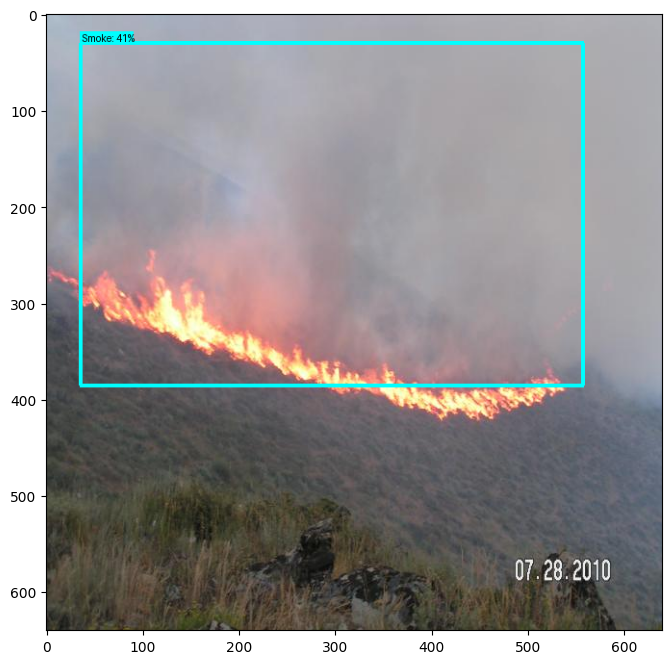

In [189]:
img = cv2.imread('/content/Wildfire_Full-1/train/11876299854_f22f787159_o_jpg.rf.c4ff32e23af66b76d10373f16e51887c.jpg')
image_np = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32
)

#detections = detect(input_tensor)
detections = detection_model(input_tensor)
label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'][0].numpy(),
    (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
    detections['detection_scores'][0].numpy(),
    category_index,
    use_normalized_coordinates=True,
    min_score_thresh=0.4
)

plt.figure(figsize=(10, 8))
plt.imshow(image_np_with_detections)
plt.show()

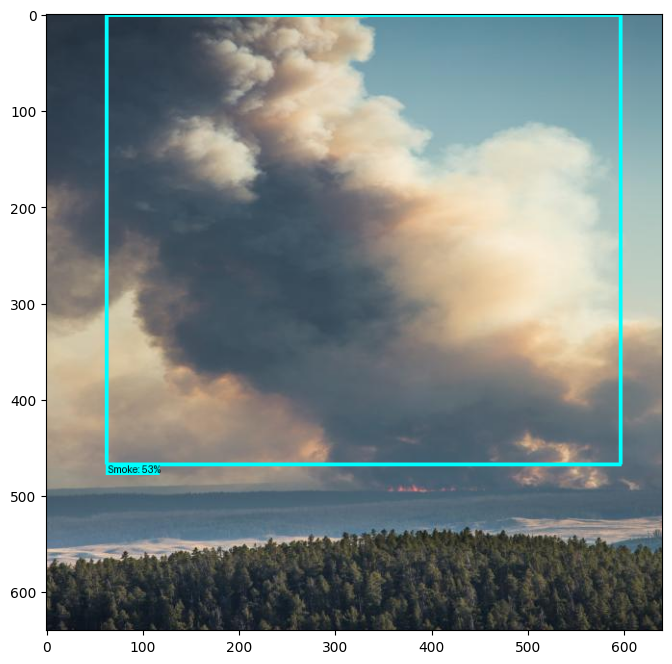

In [190]:
img = cv2.imread('/content/Wildfire_Full-1/test/21195499370_69227bf392_o_jpg.rf.dd1609903c2a4913caa9f36d06b7001d.jpg')
image_np = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32
)

detections = detect(input_tensor)
#detections = infer(input_tensor)  #Para cuando se carga el modelo
label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'][0].numpy(),
    (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
    detections['detection_scores'][0].numpy(),
    category_index,
    use_normalized_coordinates=True,
    min_score_thresh=0.5
)

plt.figure(figsize=(10, 8))
plt.imshow(image_np_with_detections)
plt.show()

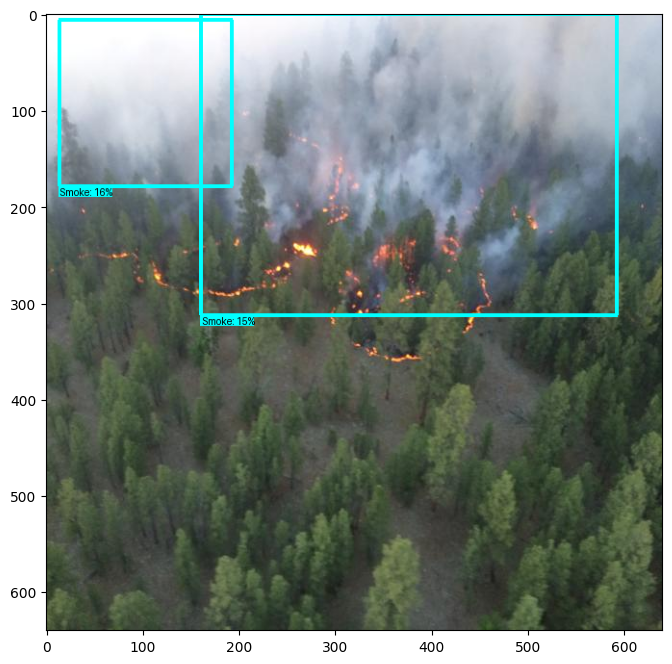

In [192]:
img = cv2.imread('/content/Wildfire_Full-1/valid/27002907153_c817ac6558_o_jpg.rf.24b995ace1204f9b7981e75bc00fa71a.jpg')
image_np = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32
)

detections = detect(input_tensor)
#detections = infer(input_tensor)
label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'][0].numpy(),
    (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
    detections['detection_scores'][0].numpy(),
    category_index,
    use_normalized_coordinates=True,
    min_score_thresh=0.15   #Aca se bajo bastante para mostrar que el modelo algo aprendio
)

plt.figure(figsize=(10, 8))
plt.imshow(image_np_with_detections)
plt.show()

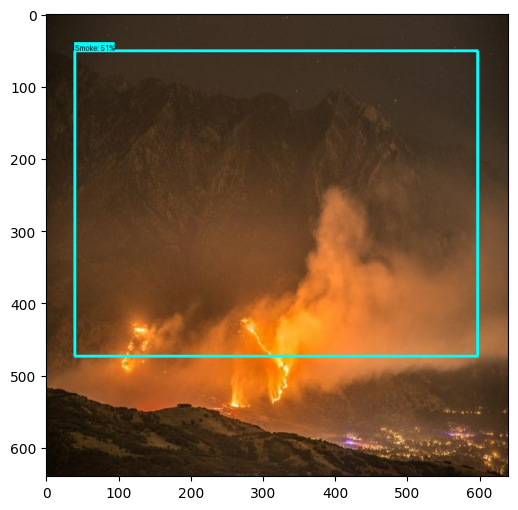

In [193]:
img = cv2.imread('/content/Wildfire_Full-1/test/37325134636_6828e71d1f_o_jpg.rf.8cd5e3558c1cd28c44cc43de45443652.jpg')
image_np = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32
)

detections = detect(input_tensor)
#detections = infer(input_tensor)
label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'][0].numpy(),
    (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
    detections['detection_scores'][0].numpy(),
    category_index,
    use_normalized_coordinates=True,
    min_score_thresh=0.5
)

plt.figure(figsize=(10, 6))
plt.imshow(image_np_with_detections)
plt.show()

#Hacemos las pruebas sobre el dataset de Validacion

In [194]:
# Ruta al archivo de anotaciones
valid_annotations_path = '/content/Wildfire_Full-1/valid/_annotations.csv'

# Leer el archivo CSV
valid_annotations_df = pd.read_csv('/content/Wildfire_Full-1/valid/_annotations.csv')

# Mostrar las primeras filas para verificar
print(valid_annotations_df.head())


                                            filename  width  height  class  \
0  walther-nunez-WSoPzcX_K3k-unsplash_jpg.rf.4dca...    640     640  Smoke   
1  52466170371_980f089a16_o_jpg.rf.492a2ac59dad74...    640     640  Smoke   
2  52466170371_980f089a16_o_jpg.rf.492a2ac59dad74...    640     640   Fire   
3  52466170371_980f089a16_o_jpg.rf.492a2ac59dad74...    640     640   Fire   
4  52466170371_980f089a16_o_jpg.rf.492a2ac59dad74...    640     640   Fire   

   xmin  ymin  xmax  ymax  
0   172     0   482   565  
1   169    10   637   339  
2   195   257   255   295  
3   253   284   341   333  
4   330   322   360   344  


In [195]:
from collections import defaultdict
import numpy as np

# Crear un diccionario donde la clave es el nombre del archivo y el valor son las cajas y clases
ground_truth = defaultdict(list)

for idx, row in valid_annotations_df.iterrows():
    filename = row['filename']
    class_id = 2 if row['class'] == 'Smoke' else 1  # Como en category dict: 1 Fire y Smoke: 2
    bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
    ground_truth[filename].append({'class_id': class_id, 'bbox': bbox})

# Ver un ejemplo
example_image = list(ground_truth.keys())[0]
print(f"Anotaciones para {example_image}: {ground_truth[example_image]}")


Anotaciones para walther-nunez-WSoPzcX_K3k-unsplash_jpg.rf.4dca61fe49a5f799623754888d877c17.jpg: [{'class_id': 2, 'bbox': [172, 0, 482, 565]}]


In [196]:
import cv2
import os

# Ruta al directorio de validación
valid_images_dir = '/content/Wildfire_Full-1/valid/'

# Lista de archivos de imagen
valid_image_files = list(ground_truth.keys())

# Preprocesar las imágenes (redimensionar a 640x640 como en el entrenamiento)
train_image_size = (640, 640)

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, train_image_size)
    image = image.astype(np.float32)
    return image

# Cargar todas las imágenes
valid_images = {}
for img_file in valid_image_files:
    img_path = os.path.join(valid_images_dir, img_file)
    valid_images[img_file] = load_and_preprocess_image(img_path)

print(f"Cargadas {len(valid_images)} imágenes de validación.")


Cargadas 177 imágenes de validación.


In [197]:
def run_inference(image_np):
    # Añadir la dimensión del batch
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = tf.expand_dims(input_tensor, axis=0)  # [1, 640, 640, 3]

    # Ejecutar la inferencia
    detections = detect(input_tensor)

    # Procesar las salidas
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                 for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # Convertir las clases a enteros
    detections['detection_classes'] = detections['detection_classes'].astype(np.int32)

    return detections


In [198]:
from tqdm import tqdm

# Diccionario para almacenar las predicciones
predictions = {}

for img_file, image_np in tqdm(valid_images.items(), desc="Realizando inferencias"):
    detections = run_inference(image_np)
    predictions[img_file] = detections


Realizando inferencias: 100%|██████████| 177/177 [11:41<00:00,  3.96s/it]


In [199]:
import json

# Estructura básica de COCO
coco_gt = {
    "images": [],
    "annotations": [],
    "categories": [
        {"id": 0, "name": "Background"},
        {"id": 1, "name": "Smoke"}
    ]
}

coco_preds = []

annotation_id = 1
for img_id, img_file in enumerate(valid_image_files, start=1):
    # Añadir información de la imagen
    coco_gt["images"].append({
        "id": img_id,
        "file_name": img_file,
        "width": train_image_size[0],
        "height": train_image_size[1]
    })

    # Añadir anotaciones
    for ann in ground_truth[img_file]:
        xmin, ymin, xmax, ymax = ann['bbox']
        width = xmax - xmin
        height = ymax - ymin
        coco_gt["annotations"].append({
            "id": annotation_id,
            "image_id": img_id,
            "category_id": ann['class_id'],
            "bbox": [xmin, ymin, width, height],
            "area": width * height,
            "iscrowd": 0
        })
        annotation_id += 1

    # Añadir predicciones
    det = predictions[img_file]
    # Dentro del bucle donde construyes coco_preds
    for score, cls, bbox in zip(det['detection_scores'], det['detection_classes'], det['detection_boxes']):
        if score < 0.01:
            continue  # Filtrar detecciones con baja confianza
        ymin, xmin, ymax, xmax = bbox
        # Convertir de [0,1] a píxeles
        xmin = xmin * train_image_size[0]
        xmax = xmax * train_image_size[0]
        ymin = ymin * train_image_size[1]
        ymax = ymax * train_image_size[1]
        width = xmax - xmin
        height = ymax - ymin
        # Asegurarse de que todos los valores son tipos nativos de Python
        coco_preds.append({
            "image_id": img_id,
            "category_id": int(cls),  # Convertir np.int32 a int
            "bbox": [float(xmin), float(ymin), float(width), float(height)],  # Convertir a float
            "score": float(score)  # Convertir a float
        })


In [200]:
# Guardar ground truth
with open('/content/ground_truth.json', 'w') as f:
    json.dump(coco_gt, f)

# Guardar predicciones
with open('/content/predictions.json', 'w') as f:
    json.dump(coco_preds, f)

print("Anotaciones y predicciones convertidas al formato COCO y guardadas.")


Anotaciones y predicciones convertidas al formato COCO y guardadas.


In [77]:
# Clonar el repositorio de COCO API
!git clone https://github.com/cocodataset/cocoapi.git

# Instalar la API de Python
%cd cocoapi/PythonAPI
!make install
%cd ../..


Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975 (from 1)
Receiving objects: 100% (975/975), 11.72 MiB | 22.91 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/cocoapi/PythonAPI
# install pycocotools to the Python site-packages
python setup.py build_ext install
running build_ext
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build/temp.linux-x86_64-cpython-310/../common
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -

In [201]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Cargar ground truth
coco_gt_api = COCO('/content/ground_truth.json')

# Cargar predicciones
coco_dt = coco_gt_api.loadRes('/content/predictions.json')

# Inicializar COCOeval
coco_eval = COCOeval(coco_gt_api, coco_dt, 'bbox')

# Ejecutar la evaluación
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.96s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Luego de entrenar por mas de 100 epocas, vemos que las metricas de precision son muy bajas, indicando el modelo no aprendio bien.

Motivos pueden ser por falta de datos (ya que por limitaciones de capacidades, se tuvo que restringir el dataset a imagenes con un solo bounding box).

De tener mas tiempo se entrenaria con Data Augmentation.

Se establecerian Callbacks para cambiar entre:
- Prioridades de loss de bounding boxes vs. Clasificacion.
- Cambios del optimizador cuando se estanca el modelo.
- Tunning d ehiperparametros.